In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [3]:
# Load the dataset
df = pd.read_csv('college_student_placement_dataset.csv')

# --- Data Cleaning ---
df.drop_duplicates(inplace=True)
df['Internship_Experience'] = df['Internship_Experience'].map({'Yes': 1, 'No': 0})
df['Placement'] = df['Placement'].map({'Yes': 1, 'No': 0})

# 1. Create a combined academic score
df['Academic_Score'] = (df['CGPA'] * 0.6) + (df['Prev_Sem_Result'] * 0.4)

# 2. Create a combined practical skills score (giving more weight to internships)
df['Practical_Score'] = (df['Internship_Experience'] * 3) + df['Projects_Completed']

# 3. Create an interaction term
df['IQ_x_CGPA'] = df['IQ'] * df['CGPA']

# --- Feature Selection (using our new features) ---
features = [
    'IQ', 
    'CGPA', 
    'Internship_Experience', 
    'Projects_Completed', 
    'Communication_Skills',
    'Academic_Score',       # New Feature
    'Practical_Score',      # New Feature
    'IQ_x_CGPA'             # New Feature
]
target = 'Placement'

X = df[features]
y = df[target]

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature engineering and scaling complete.")
print(f"New feature names: {features}")

Feature engineering and scaling complete.
New feature names: ['IQ', 'CGPA', 'Internship_Experience', 'Projects_Completed', 'Communication_Skills', 'Academic_Score', 'Practical_Score', 'IQ_x_CGPA']


In [4]:
# Define the base models (estimators)
# These models have different strengths and will provide diverse "opinions"
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)),
]

# Define the meta-model (final estimator)
# This model's job is to take the predictions from the base models and make the final decision.
meta_model = LogisticRegression(max_iter=1000)

# Create the Stacking Classifier
# The 'passthrough=True' argument means the original features will ALSO be passed to the meta-model,
# along with the predictions of the base models. This often improves performance.
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5  # Use cross-validation for the base models
)

# Train the stacking model
print("Training the Stacking Ensemble Model...")
stacking_model.fit(X_train_scaled, y_train)
print("Model training complete!")

Training the Stacking Ensemble Model...


d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "

Model training complete!


d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Placemennt_analysis_pridiction\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Stacking Model Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

  Not Placed       1.00      1.00      1.00      1668
      Placed       1.00      1.00      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



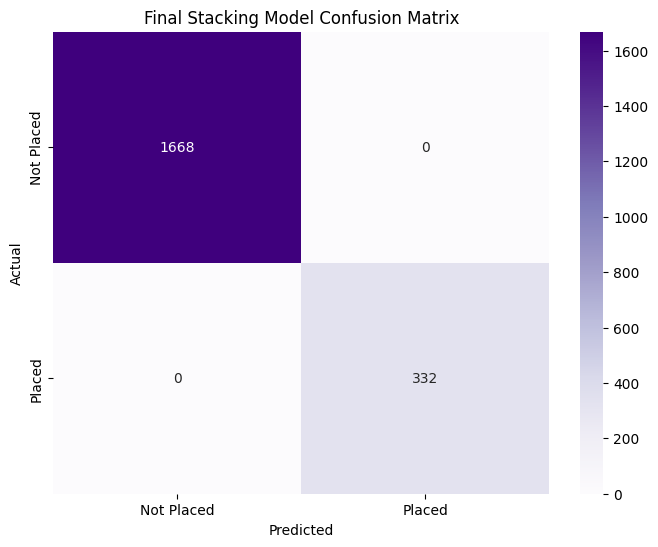

In [7]:
# Cell 4: Evaluate the Stacking Model
# Make predictions on the hold-out test set
y_pred = stacking_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Stacking Model Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Placed', 'Placed']))

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Placed', 'Placed'], yticklabels=['Not Placed', 'Placed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Stacking Model Confusion Matrix')
plt.show()

In [8]:
# Cell 5: Save the Stacking Model and the new Scaler
joblib.dump(stacking_model, 'placement_model_stacked.joblib')
joblib.dump(scaler, 'scaler_engineered.joblib')
joblib.dump(features, 'feature_list.joblib') # Also save the feature list to ensure correct order

print("Optimized stacking model saved as 'placement_model_stacked.joblib'")
print("Scaler for engineered features saved as 'scaler_engineered.joblib'")
print("Feature list saved as 'feature_list.joblib'")

Optimized stacking model saved as 'placement_model_stacked.joblib'
Scaler for engineered features saved as 'scaler_engineered.joblib'
Feature list saved as 'feature_list.joblib'
